# Makemore model


Makemore is a character level language model. Each name is a data point, there are no explicit 'features'! We extract hidden information and using those 'rules' predict/ create more names.

Bigram is a smaller version of it. Using one char to predict the next. That is our starting point. 

## Bigram 
(one character predicts the next one with a lookup table of counts)<br>
Prediction of next character. We are working on a dataset of names of children, with the final goal of creating more such 'names'. 
 

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:7]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [4]:
print(f'shortest word len = {min(len(w) for w in words)}')
print(f'biggest word len = {max(len(w) for w in words)}')

shortest word len = 2
biggest word len = 15


What is the existance of 'emma' in the dataset mean?

- e is likely to be first character
- a is likely to be last character
- m follows e, m follows m, a follows m. 
- m is likely after 'em', a is likely after 'emm'
and so on 

In [6]:
print(list(zip(words[0], words[0][1:])))

for w in words[:2]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1,ch2)

[('e', 'm'), ('m', 'm'), ('m', 'a')]
e m
m m
m a
o l
l i
i v
v i
i a


This is a clever way to exploit the functionality of `zip`. More on its functionality in the data structures expt notebook. 

Lets append `<S>` and `<E>` characters at beginning and end to indicate the start and finish characters which also conveys information. 

In [9]:
for w in words[:1]:
    # print(type(w))
    chs = ['<S>'] + list(w) + ['<E>']
    # print(type(chs))
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1,ch2)

<S> e
e m
m m
m a
a <E>


Lets apply this trasformation to the entire dataset:

In [10]:
words_transform = []

for w in words: 
    chs = '<S>' + w + '<E>'
    words_transform.append(chs)

print(words_transform[-5:]) #check last 5 entries

['<S>zylas<E>', '<S>zyran<E>', '<S>zyrie<E>', '<S>zyron<E>', '<S>zzyzx<E>']


In [11]:
# Lets generate a count of consecutive char occurances: 

b = {}

for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram,0)+1


In [13]:
print(f'Occurances of e -> a = {b[('e', 'a')]} \nOccurances of p in the end = {b[('p', '<E>')]}') 

Occurances of e -> a = 679 
Occurances of p in the end = 33


`lambda kv: -kv[1]` is equivalent to: 

```
def func(kv):
    return -kv[1]
```
i.e. `-1 * entry at index 1 of kv` is returned

In the below context, multiplying by -1 and sorting allows for descending sort, instead of the default ascending sort.

In [17]:
sorted(b.items(), key= lambda kv: -kv[1]) # sort by descending order of occurance frequency of consecutive chars

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

__Note to self:__ Understand how lambda works. 

To make this information useful, we will store it in a 2D array (2D tensor). The columns will represent the first char, the rows the second and each entry in the tensor will reflect the occurances. (like a _confusion_ matrix)

In [5]:
import torch 

N = torch.zeros(28,28, dtype=torch.int32) # 26 chars from a to z, <'S'>, <'E'>

So now we need to create a mapping from char to int in the words, so that we can simply +=1 at correct index in N each time ch1,ch2 occurs. 

In [6]:
# create a mapping of all chars to integer

chars = set(''.join(words)) # set remove duplicate elements
chars = sorted(list(chars)) # convert set to list and arrange from a -> z
# len(chars)

stoi = {s:i for i,s in enumerate(chars)} # make 'a' -> 0, 'b->1' and so on mapping
stoi['<S>'] = 26
stoi['<E>'] = 27

`chars` is basically a list of all letters: a,b,c,d....z

In [7]:
# populate N

for w in words:
    chs = ['<S>'] + list(w) + ['<E>']

    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]

        N[ix1,ix2] +=1

Lets try to visualize `N`

In [8]:
itos = {i:s for s,i in stoi.items()}

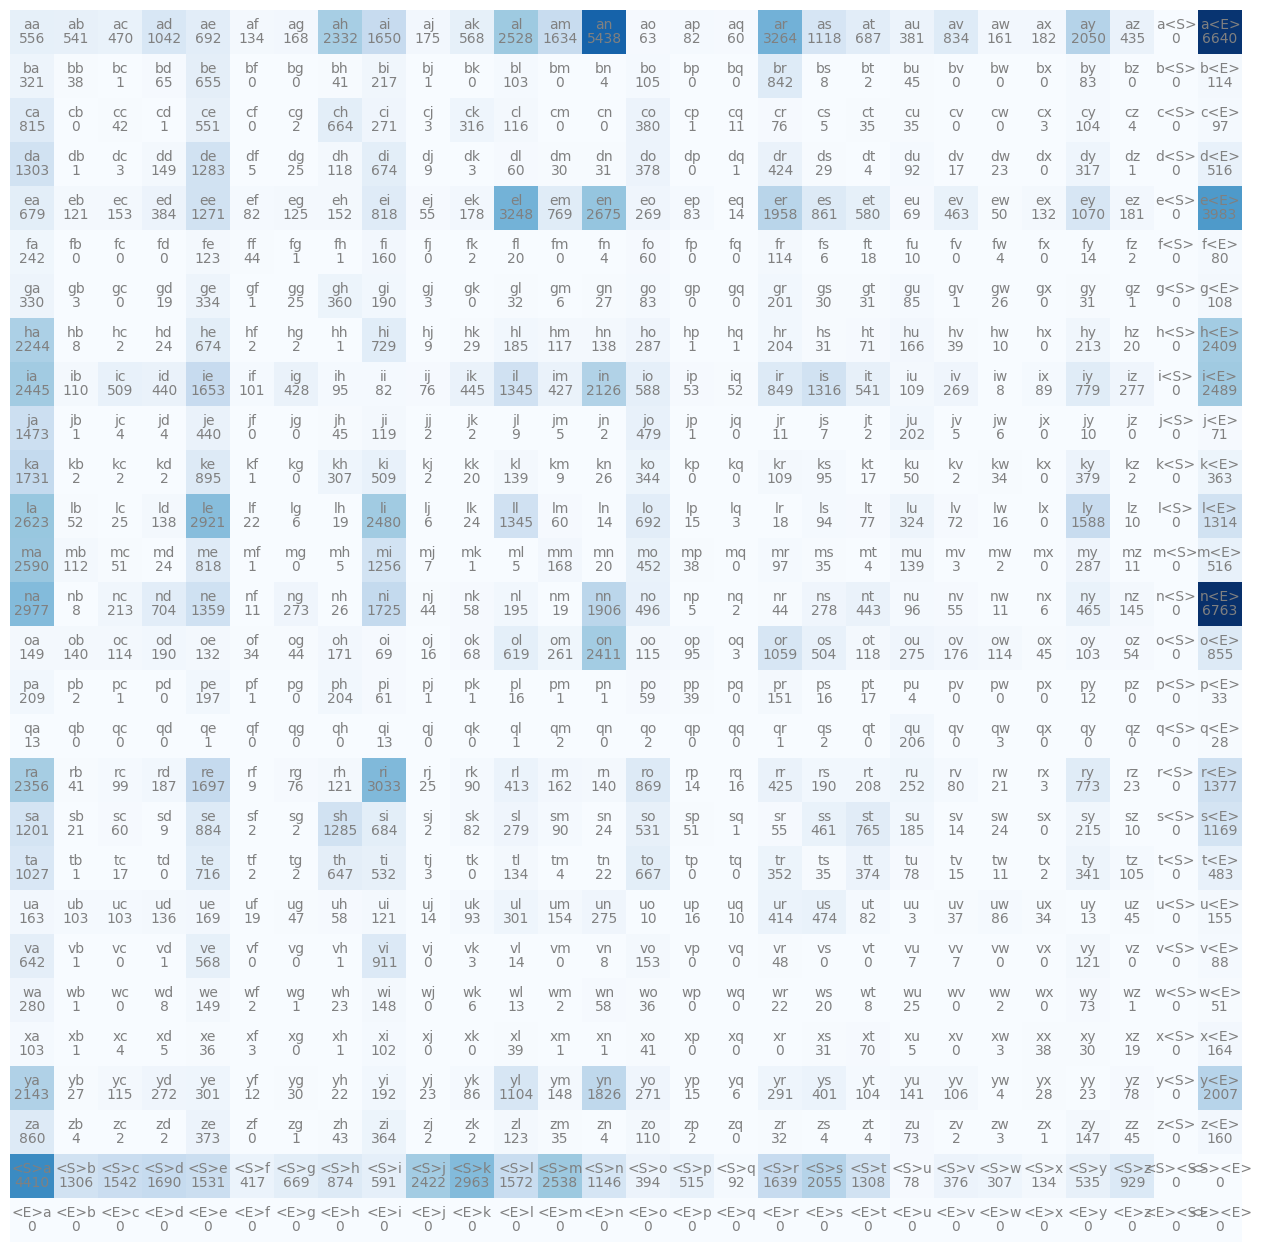

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap = 'Blues')

for i in range(28):
    for j in range(28):
        chstr = itos[i]+itos[j]
        plt.text(j , i, chstr, ha = 'center',  va = 'bottom', color = 'gray' )
        plt.text(j , i, N[i,j].item(), ha = 'center',  va = 'top', color = 'gray' )
plt.axis('off');

__Inferences:__ The last row and second last column are useless, since they will always be 0. 

To make it more efficient, we will now replace `<E>` and `<S>` with a single character `'.'` to indicate _edge_ (start or end) character. But in general, it is a convention in NLP to use `'< >'` to enclose special characters. 

In [10]:
# also shift '.' to index 0 and use mapping a -> 1, b->2 and so on.. 

stoi2 = {s:i+1 for i,s in enumerate(chars)} # make 'a' -> 0, 'b->1' and so on mapping
stoi2['.'] = 0 
# stoi2.items()
itos2 = {i:s for s,i in stoi2.items()}


In [11]:
N2 = torch.zeros((27,27), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']

    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi2[ch1]
        ix2 = stoi2[ch2]

        N2[ix1,ix2] +=1

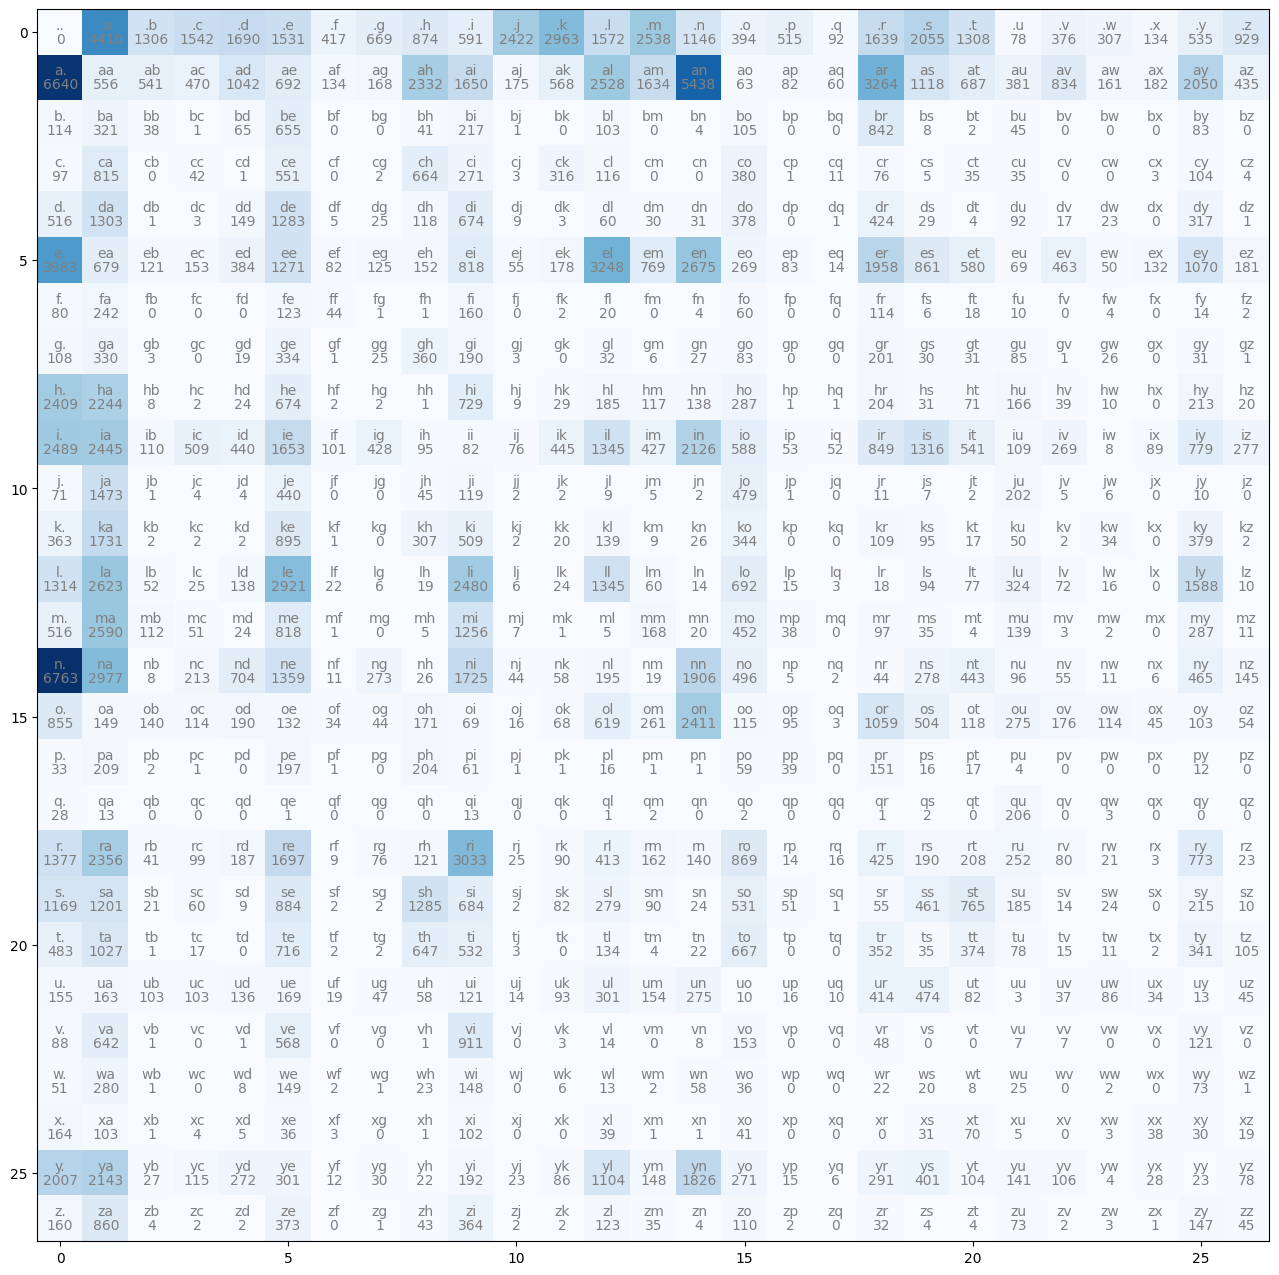

In [12]:
plt.figure(figsize=(16,16))
plt.imshow(N2, cmap = 'Blues')

for i in range(27):
    for j in range(27):
        chstr = itos2[i]+itos2[j]
        plt.text(j , i, chstr, ha = 'center',  va = 'bottom', color = 'gray' )
        plt.text(j , i, N2[i,j].item(), ha = 'center',  va = 'top', color = 'gray' )

__Interpretation__:

- `N2[0,0]` = 0 makes sense since there are no empty words (`..`)
- `y.` -> y is the last char
- `.b` -> b is the first letter 
- we have also managed to remove the extra row/column that was appearing with `<S>` and `<E>`
- Rest all cells indicate occuranges of that char string across all names

In [23]:
N2[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [14]:
# probability distribution of first character!
p = N2[0].float()

p = p/p.sum()
p, p.sum()

(tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
         0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
         0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290]),
 tensor(1.))

To Sample from this distribution for the first character, we will use the __multinomial distribution__ in `torch.multinomial`

__Sample implementation of `torch.multinomial`:__

In [25]:
g = torch.Generator().manual_seed(233476)
pdr = torch.rand(3, generator=g)
pdr = pdr / pdr.sum()
pdr

tensor([0.1236, 0.6447, 0.2317])

using `pdr` to be be the multinomial probability distribution for 0,1,2 lets create 10 samples :

We roughly expect $0:1:2$ to be $0.12:0.64:0.23$

In [28]:
pdr_samples = torch.multinomial(pdr, num_samples=100, replacement=True, generator=g)
counts = torch.zeros(3)

counts = ((pdr_samples == 0).sum().item(), (pdr_samples == 1).sum().item(), (pdr_samples == 2).sum().item())
counts

(14, 62, 24)

This above ratio is indeed close to the expected probabilities and will vary each time the above cell is run. 

In [29]:
# another way to fetch counts of unique entries in a tensor. Similar to numpy.

values, counts = torch.unique(pdr_samples, return_counts=True)
print(dict(zip(values.tolist(), counts.tolist())))

{0: 14, 1: 62, 2: 24}


## Intuition for Bigram:

(Using multinomial distribution for sampling) `hi`

Steps:
<ol>
    <li> Sample first character based on probabilities in `N2[0]` -- say returns `m`
    <li> Go to row of bigrams in which first letter is `'m'` i.e. `N2[stoi2['m']]`
    <li> Sample from `N2[stoi2['m']]` -- say returns `'ma'`
    <li>  Bigram is ready!
</ol>

Now lets implement a loop for this to furnish our set of bigrams. 

In [15]:
g = torch.Generator().manual_seed(236545)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(ix, itos2[ix])

19 s


Lets churn names through a while loop:

In [24]:
g1 = torch.Generator().manual_seed(42)

for  i in range (10):
    out = []
    idx = 0
    while True:
        p = N2[idx].float() # initialize row for a character
        p1 = p/p.sum()
        idx= torch.multinomial(p1, num_samples=1, replacement=True, generator=g1).item()       
        out.append(itos2[idx])
        if idx == 0 and len(out)>1: # '.' is encountered
            break 
    print(''.join(out))


ya.
syahavilin.
dleekahmangonya.
tryahe.
chen.
ena.
da.
amiiae.
a.
keles.


__Observation:__ Clearly the bigram names are not very 'name-like'. There is no element of _intelligence_ here, it simply multinomial sampling. 


<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">NOTE:</span> I'm unable to understand why there such unusually long names before a '.' which is still fine; but why are repetitions and vowel sequences no HIGH???<br>
But suddenly the above problem stopped happening?! There generator argument is _very weird_. 

Doesn't seem to be the case in Andrej's notebook. 

__Edit on above issue:__ I was referring to the wrong variable which skewed my probability sampling. Phew!

In [38]:
# lets experiment with a uniform probability distribution: 

g2 = torch.Generator().manual_seed(34467)

for i in range(5):
    indx = 0
    out1 = []
    while True:
        p2 = torch.ones(p.shape) # p = N[0] is defined above
        p2 = p2/p2.sum()
        indx = torch.multinomial(p2, num_samples=1, replacement=True, generator=g2).item()
        s = itos2[indx]
        out1.append(s)

        if indx == 0:
            break
    print(''.join(out1))

zjaystplcwusxvlbuevnlwzalumvmmgcusdbjtpnqopv.
nwphzilsxqdkh.
ekmumvgyszncoedwslgooaapcifknzkqmbnstvfsribzewxdntkaaixhvs.
wfzsdhgbgyknscxpyxsgtiiwyeatnwptuxiorzri.
ismkjauarcequefzpvsilhmbqydtftxwcizgjwjmajtyfzaetvqtwjzsmfykymaehnmkqekirr.


So when we compare the bigram output of uniform distribution vs learned distribution, we see that bigram names are relatively _closer_ to real names!

```
p = N2[idx].float()
p1 = p/p.sum()
```

is repetitive and instead lets just replace the matrix N to contain porbabilities directly, to make it more efficient. 

In [ ]:
P = N2.float() # can be smoothed by defining as P = (N2+1).float() instead
P_sum = P.sum(dim = 1, keepdim=True)
P = P / P_sum

To get a glimpse of the normalize P matrix, lets visualize a small subsection:

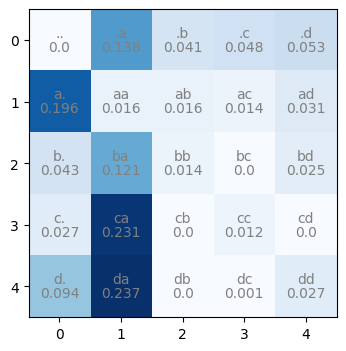

In [50]:
mini_P = P[:5, :5]
plt.figure(figsize=(4,4))
plt.imshow(mini_P, cmap = 'Blues')

for i in range(5):
    for j in range(5):
        chstr = itos2[i]+itos2[j]
        plt.text(j , i, chstr, ha = 'center',  va = 'bottom', color = 'gray' )
        plt.text(j , i, round(mini_P[i, j].item(), 3), ha = 'center',  va = 'top', color = 'gray' )

In [49]:
# Note
P.shape, P_sum.shape

(torch.Size([27, 27]), torch.Size([27, 1]))

P is our probability matrix derived from N2 now. 

__For more on rules of broadcasting to increase efficiency, refer to data structure notebook in this repo.__

## Loss Function 

To measure quality of the model through a single number. The following is the chain of thought to arrive at loss minimization via NLL (negative log likelihood): 

<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">GOAL:</span> Maximize the likelihood of the training dataset wrt to model params (which are `P[ch1,ch2]` in our case)

`P[ch1,ch2]` is probability of bigram 

- maximizing likelihood = max log likelihood, since log is monotonic = minimizing NLL = minimizing avg NLL

__Explanation for adding loglikelihoods:__

P(dataset) = $ \prod_{1}^{m} P(b_{i1}, b_{i2})$

i.e. P(dataset) = product of probabilities of all bigrams in the dataset _given_ parameter `P` we _learnt_ from the dataset. <br>
$\implies$ This very product turns into a sum when log is applied. 

In [53]:
log_likelihood = 0.0
n = 0

for w in words[:3]:
    chs = ['.'] + list(w) + ['.']

    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi2[ch1]
        ix2 = stoi2[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob # explanation below
        n+=1
        print(f'P[{ch1}{ch2}]: {prob:.4f} {logprob:.4f}')

print('log likelihood = ', log_likelihood.item())

NLL = -log_likelihood.item()
print('NLL = ', NLL)

print('avg loss = ', (1/n)*NLL)

P[.e]: 0.0478 -3.0408
P[em]: 0.0377 -3.2793
P[mm]: 0.0253 -3.6772
P[ma]: 0.3899 -0.9418
P[a.]: 0.1960 -1.6299
P[.o]: 0.0123 -4.3982
P[ol]: 0.0780 -2.5508
P[li]: 0.1777 -1.7278
P[iv]: 0.0152 -4.1867
P[vi]: 0.3541 -1.0383
P[ia]: 0.1381 -1.9796
P[a.]: 0.1960 -1.6299
P[.a]: 0.1377 -1.9829
P[av]: 0.0246 -3.7045
P[va]: 0.2495 -1.3882
P[a.]: 0.1960 -1.6299
log likelihood =  -38.78563690185547
NLL =  38.78563690185547
avg loss =  2.424102306365967


In [59]:
# lets check loss of some names not in the dataset:

names = ['andrej']

log_likelihood = 0.0
n = 0

for w in names:
    chs = ['.'] + list(w) + ['.']

    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi2[ch1]
        ix2 = stoi2[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob # explanation below
        n+=1
        print(f'P[{ch1}{ch2}]: {prob:.4f} {logprob:.4f}')

print('log likelihood = ', log_likelihood.item())

NLL = -log_likelihood.item()
print('NLL = ', NLL)

print('avg loss = ', (1/n)*NLL)

P[.a]: 0.1377 -1.9829
P[an]: 0.1605 -1.8296
P[nd]: 0.0384 -3.2594
P[dr]: 0.0771 -2.5620
P[re]: 0.1336 -2.0127
P[ej]: 0.0027 -5.9171
P[j.]: 0.0245 -3.7098
log likelihood =  -21.273456573486328
NLL =  21.273456573486328
avg loss =  3.039065224783761


The loss is esp high on 'ej' since probability of ej occuring in the training dataset is very low! So avg loss is higher than that on the names of the dataset. 

If we add a name such as 'anupq' where $P(pq) = 0$, avg loss will become $\infty$. To avoid this, we can __smoothen the probabilities__ `P` (ex. Laplace smoothening) as such while creating from N2: `P = (N2+1).float()`


### Way forward

To esitmate `P` we are simply counting so far. But we will use neural networks to calculate P, and tweak its parameters to get a lower loss. 